In [1]:
import wikipedia
wikipedia.set_lang('en') # setting wikipedia language
import wikipediaapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from time import sleep
import sys

import nltk # for nlp on articles
#nltk.download("stopwords")
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# I. Data Acquisition

## Data Acquisition Utils

In [2]:
class DataAquisitionUtils():

    @staticmethod
    def fetch_category_members(category_members, level=0, max_level=1):
        """
        Function to take all article in category (max_level control the depth of articles taken from the subcategories)
        Arguments:
        category_members - a list of category members
        level - the level at which to start getting articles
        max_level - the maximal level for the fetched articles
        Returns:
        list_articles - a list of the desired articles
        """
        return 0
        list_articles = []
        for c in category_members.values():
            if c.ns == 0:
                list_articles.append(c) 
                #print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
            elif level < max_level and c.ns == 14:
                sub_list = []
                sub_list = DataAquisitionUtils.fetch_category_members(c.categorymembers, level=level + 1, max_level=max_level)
                list_articles = list_articles + sub_list
        return list_articles

    @staticmethod
    def hyperlinks_matrix(list_articles):
        """
        Computes an adjacency matrix with the hyperlinks between the different articles in the argument given
        Arguments:
        list_articles - a list of articles for which to compute the hyperlink matrix
        Returns:
        matrix - a binary matrix A where A[i,j] = 1 if article i has a hyperlinkt to article j, and A[i,j] = 0 otherwise
        """
        len_time = len(list_articles)*0.05
        matrix = np.zeros((len(list_articles), len(list_articles)))
        compt = 0
        for article in list_articles:
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int(compt/len_time), int(5*compt/len_time)))
            sys.stdout.flush()
            sleep(0.25)
            for link in article.links:
                for i in range(len(list_articles)):
                    if (link == list_articles[i].title):
                        matrix[compt,i] = 1
            compt = compt + 1
        return matrix
    
    @staticmethod
    def take_words(list_articles, stop_words, is_title = False):
        """
        Function that tokenizes and returns all words in the list of articles given
        Arguments:
        list_articles - list of articles
        is_title - whether the list contains pages or just strings of titles
        Returns:
        words_df - the words in the articles in a dataframe
        """
        words_df = pd.DataFrame(columns=['article', 'words'])
        for i in range(len(list_articles)):
            if (i%100 == 0) :
                print(i)
            try: 
                if (is_title == False):
                    page = wikipedia.page(list_articles[i].title)
                else:
                    page = wikipedia.page(list_articles[i])
            except wikipedia.DisambiguationError as e:
                s = e.options
                s = list(filter(lambda x : x != "", s))
                try :
                    page = wikipedia.page(s)
                except wikipedia.DisambiguationError as e:
                    pass
            except wikipedia.PageError:
                pass
            words = word_tokenize(page.content)
            words = [elem.lower() for elem in words]
            words = [elem for elem in words if len(elem) > 1 and elem.isdigit() == False]
            words_wostop = [x for x in words if x not in stop_words]
            words_wostop = [elem.lower() for elem in words_wostop]
            if (is_title == False):
                words_df.loc[i] = [list_articles[i].title] + [words_wostop]
            else:
                words_df.loc[i] = [list_articles[i]] + [words_wostop]
        return words_df
    
#     @staticmethod
#     def make_features(words, important_words_df, weights = True):
#         explode_df = words.explode('words')
#         if (weights == True) :
#             explode_df = explode_df.merge(important_words_df, on = 'words', how = 'right')
#             df = pd.DataFrame(words['article']).assign(key = 1).merge(pd.DataFrame(important_words_df['words']).assign(key = 1), on = 'key').drop('key', 1)
#             df2 = df.merge(explode_df, on = ['article','words'] , how = 'left').drop_duplicates().fillna(0)
#             df3 = pd.pivot_table(df2, values = 'tfidf',  index = 'article', columns=['words'])
#         else : 
#             explode_df['exist'] = np.ones(len(explode_df))
#             df = pd.DataFrame(words['article']).assign(key = 1).merge(pd.DataFrame(important_words_df['words']).assign(key = 1), on = 'key').drop('key', 1)
#             df2 = df.merge(explode_df, on = ['article','words'] , how = 'left').drop_duplicates().fillna(0)
#             df3 = pd.pivot_table(df2, values = 'exist',  index = 'article', columns=['words'])
#         display(df3.head(10))
#         features = df3.values
#         return features

## NLP Utilities

In [3]:
class NLPUtilities():
    
    @staticmethod
    def TF_IDF(words_df, nb_words):
        """
        Function to get the words with the top TF-IDF scores
        Arguments:
        words_df - the dataframe consisting of the words to be considered
        nb_words - the number of words we would like the function to return
        Returns:
        df - a dataframe containing the words with the best TF-IDF scores
        """
        #remove strings like "10,000"
        #religion_df['words'] = religion_df['words'].apply(lambda word_list: list(filter(lambda word: (',' not in word), word_list)))
        #only keep strings that contain alphabet chars
        words_df['words'] = words_df['words'].apply(lambda word_list: list(filter(lambda word: word.isalpha(), word_list)))
        # create a column with all words concatenated
        words_df['words_string'] = words_df['words'].apply(lambda words_list: " ".join(words_list))

        cv=CountVectorizer()
        word_count_vector=cv.fit_transform(words_df['words_string'])

        tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
        tfidf_transformer.fit(word_count_vector)

        # count matrix
        count_vector=cv.transform(words_df['words_string'])

        # tf-idf scores
        tf_idf_vector=tfidf_transformer.transform(count_vector)

        feature_names = cv.get_feature_names()
        
        dense = tf_idf_vector.todense()
        denselist = dense.tolist()
                
        #tf_idf = matrix where rows are articles and columns are words and values are tfidf score for word in article
        tf_idf = pd.DataFrame(data=denselist, columns=feature_names, index=words_df['article'])
        
        #these are the words that have the biggest tfidf score
        important_words = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf']).head(nb_words).index.values
        
        #only keep the most important words in matrix
        tf_idf = tf_idf[important_words]

        return tf_idf

## Data Acquisition Pipeline

### Fetching the articles of interest

In [4]:
aquire = DataAquisitionUtils()

In [5]:
wiki_wiki = wikipediaapi.Wikipedia('en') # getting articles in english
# fetching the articles for categories of interest
religion_page = wiki_wiki.page("Category:Religion")
science_page = wiki_wiki.page("Category:Science")

In [6]:
# EXECUTE IF YOU DO NOT HAVE PICKLES
# religion_articles = aquire.fetch_category_members(religion_page.categorymembers,0,1)
# science_articles = aquire.fetch_category_members(science_page.categorymembers)

In [7]:
religion_articles = pd.read_pickle('./religion_articles')
science_articles = pd.read_pickle('./science_articles')

#### Hyperlink matrix

In [8]:
# EXECUTE IF YOU DO NOT HAVE CSV
# list_articles = religion_articles + science_articles
# adjacency_matrix = aquire.hyperlinks_matrix(list_articles)
# num_edges = np.count_nonzero(adjacency_matrix)
# print(f"Number of edges in the feature graph: {num_edges}")
# np.savetxt('hyperlinks.csv', adjacency_matrix)

In [11]:
df = pd.read_csv('./hyperlinks.csv.zip')

### Taking the words with the highest TF-IDF

In [13]:
#Take all the words present in the articles that are not stopwords
stop_found = ['====', '===', '==', '<<', '>>', "''", '``', "'s" , '\displaystyle', '...', '\phi', '\mu', '\mathbf', '--', 'x_',
        '\alpha', '\dot', '\hat', '\lambda', '\left', '\right', 'mathcal', '\nu', '\partial'] #getting the stopwords found in the articles after exmination
stop_pre = stopwords.words('english') # getting the common english stopwords
stop_words = stop_found + stop_pre

In [14]:
#religion_df = aquire.take_words(religion_articles, stop_words)
religion_df = religion_articles
religion_df = religion_df.drop_duplicates('article')

In [15]:
#science_df = aquire.take_words(science_articles, stop_words)
science_df = science_articles
science_df = science_df.drop_duplicates('article')

In [16]:
religion_labeled_df = religion_df.copy()
religion_labeled_df['label'] = 0

science_labeled_df = science_df.copy()
science_labeled_df['label'] = 1

#words_df_reduced = pd.concat([religion_labeled_df[:int(len(religion_labeled_df)/10)],\
#                      science_labeled_df[:int(len(science_labeled_df)/10)]], ignore_index=True)
words_df_reduced = pd.concat([religion_labeled_df[:700], science_labeled_df[:700]], ignore_index=True)
                              
labels_df = words_df_reduced['label']
words_df_reduced

,article,words,label
0,Religion,"[religion, social-cultural, system, designated...",0
1,African and African-American women in Christia...,"[christianity, africa, began, egypt, middle, 1...",0
2,Religion and agriculture,"[religion, agriculture, closely, associated, s...",0
3,American Anglican Church,"[anglican, church, north, america, acna, chris...",0
4,American Humanist Association,"[american, humanist, association, aha, non-pro...",0
...,...,...,...
1395,Scientific equipment optician,"[scientific, equipment, optician, individual, ...",1
1396,Volcanologist,"[volcanologist, vulcanologist, geologist, stud...",1
1397,Allen Brain Atlas,"[allen, mouse, human, brain, atlases, projects...",1
1398,Allen Institute for Brain Science,"[allen, institute, brain, science, seattle-bas...",1


In [17]:
nlpu = NLPUtilities()

In [36]:
# UNCOMMENT & EXECUTE IF YOU DO NOT HAVE tf_idf_1400_articles.pickle
#tf_idf = nlpu.TF_IDF(words_df_reduced, 100)
tf_idf = pd.read_pickle('tf_idf_1400_articles.pickle')
tf_idf

,science,religion,religious,also,god,book,scientific,research,one,church,...,review,spiritual,information,system,however,john,islam,group,years,based
article,,,,,,,,,,,,,,,,,,,,,
Religion,0.040566,0.543287,0.261171,0.040955,0.040272,0.005691,0.020897,0.000000,0.059069,0.035598,...,0.004107,0.03139,0.000000,0.030415,0.026056,0.013743,0.075973,0.026332,0.000000,0.023621
African and African-American women in Christianity,0.000000,0.023470,0.039923,0.033911,0.006669,0.005654,0.000000,0.005804,0.013043,0.219298,...,0.000000,0.00000,0.007334,0.000000,0.028767,0.000000,0.053285,0.019623,0.006092,0.005868
Religion and agriculture,0.000000,0.069755,0.000000,0.040315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069755
American Anglican Church,0.000000,0.001558,0.003028,0.017105,0.005311,0.006004,0.000000,0.000000,0.012696,0.259163,...,0.000000,0.00000,0.000000,0.000000,0.003055,0.003625,0.002358,0.003473,0.004852,0.000000
American Humanist Association,0.000000,0.009570,0.046511,0.019358,0.038071,0.000000,0.000000,0.004733,0.007091,0.011538,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.016704,0.000000,0.005334,0.004968,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Scientific equipment optician,0.000000,0.000000,0.000000,0.049731,0.000000,0.000000,0.029000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.100127,0.000000,0.000000,0.000000,0.000000
Volcanologist,0.023798,0.000000,0.000000,0.016018,0.015751,0.000000,0.000000,0.027415,0.010268,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.013588,0.000000,0.000000,0.015448,0.014387,0.000000
Allen Brain Atlas,0.022973,0.000000,0.000000,0.018039,0.000000,0.000000,0.000000,0.070573,0.003304,0.000000,...,0.000000,0.00000,0.016720,0.005104,0.004372,0.000000,0.000000,0.004971,0.004629,0.004459


In [19]:
important_words_df = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf'])
important_words_df

,tfidf
science,52.716979
religion,38.608664
religious,34.886210
also,26.213901
god,26.073406
...,...
john,8.422473
islam,8.327312
group,8.310144
years,8.304601


In [20]:
# we don't really need the function make_features anymore 
# features = aquire.make_features(words_df_reduced, important_words_df.reset_index().rename(columns={'index':'words'}))

The weighted TF-IDF matrix $W_{w}$ is our tf_idf dataframe.

In [21]:
features_weight = tf_idf

For the non-weighted TF-IDF $W_{nw}$ where we compute the weights such that for all $i,j$

$(W_{nw})_{i,j} = 1$ if $(W_{w})_{i,j} > 0$, $(W_{nw})_{i,j} = 0$ otherwise

we can do the following

In [22]:
features_no_weight = tf_idf.where(tf_idf <= 0, 1)

For the rest of this project we choose to work with the weighted TF-IDF matrix as it gives more insights into word importance.

In [23]:
features = features_weight

We have hence aquired the data and put it in a dataframe called features. Its rows are the different articles and each column is an important word (according to TF-IDF scores).

# II. Data Exploration

In [24]:
from scipy.spatial.distance import pdist, squareform
import operator
from sklearn.manifold import TSNE

## Matrix Utilities

In [25]:
class MatrixUtils():
    
    @staticmethod
    def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
        """ 
        Fnction to compute the epsilon similarity graph seen in class
        Arguments:
        X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Returns:
        adjacency (n x n ndarray): adjacency matrix of the graph.
        """
        adjacency = squareform(pdist(X))
        adjacency = np.exp((- adjacency**2)/(2 * sigma**2))
        adjacency[adjacency < epsilon] = 0
        #according to the formula on slide 11 in the spectral clustering lecture, we set the diagonal to 0
        np.fill_diagonal(adjacency,0)
        return adjacency
    
    @staticmethod
    def compute_laplacian(adjacency: np.ndarray, normalize: bool):
        """ 
        Function to compute the laplacian
        Arguments:
        adjacency - an adjacency matrix for which to compute the laplacian
        normalize - if set to True, the normalized laplacian is returned, otherwise the combinatorial one is returned 
        Returns:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
        """
        degrees_l = np.sum(adjacency,axis=1)
        if(not normalize):
            degrees = np.zeros(adjacency.shape)
            np.fill_diagonal(degrees,degrees_l)
            return degrees - adjacency 
        else:
            degrees = np.sqrt(np.array([degrees_l]).T @ np.array([degrees_l]))
            L = - adjacency/degrees
            np.fill_diagonal(L,np.ones(len(adjacency)))
            return L
    
    @staticmethod
    def spectral_decomposition(laplacian: np.ndarray):
        """
        Function to carry out spectral decomposition on a given matrix
        Arguments:
        laplacian - matrix on which to carry out decomposition
        Returns:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
        """
        values, vectors = np.linalg.eig(laplacian)
        sorted_indices = np.argsort(values)
        return values[sorted_indices], vectors[:,sorted_indices]
    
    @staticmethod
    def GFT(signal: np.ndarray):
        """
        Function to compute the fourier transform of a signal
        Arguments:
        signal - the signal for which to compute the fourier transform (in the form of an Numpy array)
        Returns:
        fourier - the fourier transform of the signal provided
        """
        fourier = U.transpose()@signal
        return fourier
    
    @staticmethod
    def iGFT(fourier_coefficients: np.ndarray):
        """
        Function to compute the signal from a fourier transform
        Arguments:
        fourier_coefficients - the fourier coefficients from which to get the signal (in the form of an Numpy array)
        Returns:
        signal - the signal for the fourier coefficients given
        """
        signal = U@fourier_coefficients
        return signal

## Filter Utilities

In [26]:
class FilterUtilities():
    
    @staticmethod    
    def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
        """
        Function to apply an idea filter to a graph
        Arguments:
        x - the signal on which to apply the filter
        spectral_response - the spectral response of the signal
        Returns:
        filtered_graph - a filtered signal
        """
        fourier = MatrixUtils().GFT(x);
        h = np.diag(spectral_response)
        filtered_graph = U@h@fourier
        return filtered_graph

In [27]:
class VisUtils():
    
    @staticmethod
    def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
        """
        Function to compute the laplacian eigenmap if a given matrix
        Arguments:
        X - the matrix for which to compute the eigenmaps
        dim - the dimension of the data we would like to return
        sigma - the sigma parameter for the epsilon similarity graph
        epsilon - the epsilon parameter for the epsilon similarity graph
        normalize - if set to True, the normalized laplacian is used, otherwise the combinatorial one is used 
        Returns:
        coords (n x dim array): new coordinates for the data points
        """
        adjacency = MatrixUtils().epsilon_similarity_graph(X, sigma, epsilon)
        laplacian = MatrixUtils().compute_laplacian(adjacency, normalize)
        eigenvalues, eigenvectors = MatrixUtils().spectral_decomposition(np.nan_to_num(laplacian)) 
        return (eigenvectors[:,1:dim+1])

## Exploring graph properties

In [28]:
from numpy import dot
from numpy.linalg import norm

def cosine(a,b):
    """
    Function to compute the cosine similarity between two vectors
    Arguments:
    a - first vector
    b - second vector
    Returns:
    cos_sim - the cosine similarity between a and b
    """
    if(norm(a) == 0 or norm(b) == 0):
        return dot(a,b)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

In [29]:
features_a = np.array(features)

In [30]:
distances = np.array(
    [
        [
            cosine(features_a[i,:],features_a[j,:]) for i in range(0,features_a.shape[0])
        ]
        for j in range(0,features_a.shape[0])
    ]
    ).reshape(features.shape[0],-1)

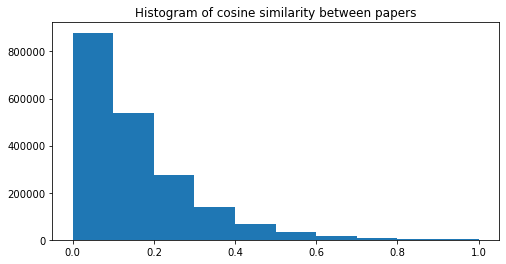

In [31]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of cosine similarity between papers")
plt.hist(distances.flatten());

We notice a heavy-tailed distribution. The similarity between papers is hence concentrated around 0 and 0.2 between most papers but there are some rare papers with very high cosine similarity scores.

In [32]:
important_words_df.head(20)

,tfidf
science,52.716979
religion,38.608664
religious,34.886210
also,26.213901
god,26.073406
book,24.822986
scientific,23.692436
research,22.570687
one,21.420285
church,20.377060


In [33]:
distances = np.nan_to_num(distances)

Let's examine an example of distance distribution for one of the papers.

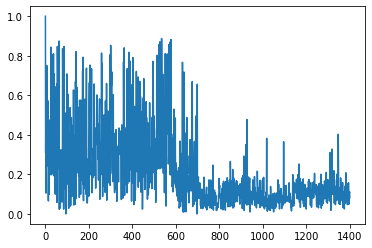

In [34]:
plt.plot(distances[0])

In [39]:
def article_sim_th(threshold, distances=distances):
    feat = np.where(distances > threshold, 1, 0)
    np.fill_diagonal(feat, 0)
    return feat

In [40]:
adjacency_matrix = article_sim_th(0.6)

In [42]:
# building a graph using the normalized distances
graph = nx.from_numpy_matrix(adjacency_matrix)

In [43]:
# assessing the giant component size
giant_feature = max(nx.connected_component_subgraphs(graph), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 1264 nodes and 13639 edges.


In [44]:
# getting the average clustering coefficient of our graph
nx.average_clustering(graph)

0.4904574575937421

## Exploring possible clustering in the graph

In [45]:
matrixu = MatrixUtils()

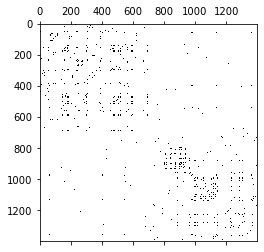

In [46]:
plt.spy(adjacency_matrix)
plt.show()

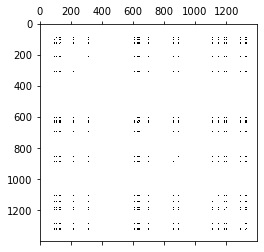

In [47]:
adjacency = matrixu.epsilon_similarity_graph(adjacency_matrix, sigma= 10*np.mean(adjacency_matrix), epsilon=0.2)
plt.spy(adjacency)
plt.show()

In [48]:
import operator
pr = nx.pagerank(graph)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse = True)

In [49]:
sorted_pr

[(141, 0.0022892562700181163),
 (888, 0.0022018951756121365),
 (376, 0.0021703103031869083),
 (388, 0.00216482688413386),
 (1149, 0.002121851524451258),
 (297, 0.002116721270151282),
 (419, 0.0021010528137721533),
 (0, 0.0020973334279591653),
 (700, 0.002060695661624799),
 (40, 0.0020074828235951457),
 (990, 0.001979612705459857),
 (1267, 0.001973039209143982),
 (7, 0.0019582717335900404),
 (1281, 0.0019507332411855655),
 (1282, 0.0019507332411855655),
 (1039, 0.001939817884186629),
 (300, 0.0018886265331534283),
 (755, 0.001883701527333678),
 (515, 0.0018823457922378152),
 (432, 0.0018810654654848533),
 (521, 0.0018788085367901603),
 (567, 0.0018788085367901603),
 (145, 0.0018758336469003158),
 (573, 0.001860680755021183),
 (301, 0.0018390733008486289),
 (305, 0.0018308625360945947),
 (1160, 0.0018232534839249656),
 (919, 0.0018023528332838576),
 (1311, 0.0017997944228047723),
 (304, 0.0017960110496142774),
 (1300, 0.0017947843211776606),
 (1112, 0.0017872619425654617),
 (928, 0.00177

In [50]:
sorted_pr[:10]

[(141, 0.0022892562700181163),
 (888, 0.0022018951756121365),
 (376, 0.0021703103031869083),
 (388, 0.00216482688413386),
 (1149, 0.002121851524451258),
 (297, 0.002116721270151282),
 (419, 0.0021010528137721533),
 (0, 0.0020973334279591653),
 (700, 0.002060695661624799),
 (40, 0.0020074828235951457)]

## Exploring possible clustering in the graph after passing it through an ideal filter

In [51]:
# Computing the laplacian
laplacian = matrixu.compute_laplacian(adjacency, normalize=True)
lam, U = matrixu.spectral_decomposition(np.nan_to_num(laplacian))

C:\Users\lilia\.conda\envs\ntds_2019\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


In [52]:
alpha = 0.99 / np.max(lam)

ideal_tk =  1/(1 + alpha*lam)

In [53]:
filt = FilterUtilities().ideal_graph_filter(adjacency.tolist(),ideal_tk)

In [54]:
graph_filt = nx.from_numpy_matrix(filt)

C:\Users\lilia\.conda\envs\ntds_2019\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


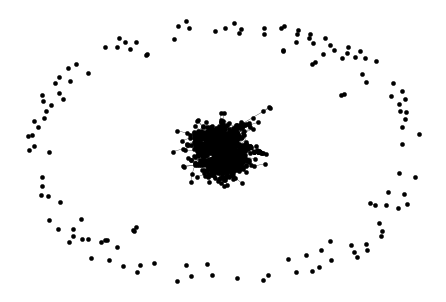

In [55]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph, **options)

C:\Users\lilia\.conda\envs\ntds_2019\lib\site-packages\scipy\sparse\coo.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  self.data = self.data.astype(dtype, copy=False)


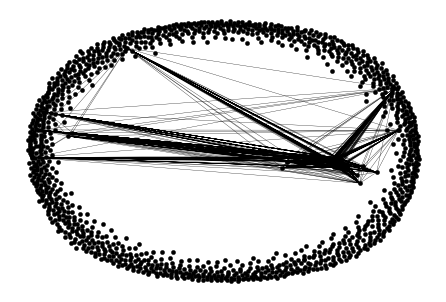

In [56]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph_filt, **options)

In [57]:
giant_features = max(nx.connected_component_subgraphs(graph_filt), key = len)

TypeError: can't convert complex to float

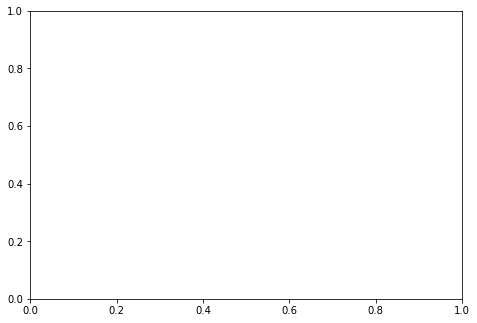

In [58]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(giant_features, **options)

In [59]:
giant_features.nodes

NodeView((513, 1035, 14, 533, 29, 541, 544, 1057, 38, 1066, 45, 51, 1077, 1080, 1084, 585, 1107, 601, 93, 606, 609, 1126, 105, 624, 626, 627, 628, 629, 1140, 632, 633, 1146, 635, 1147, 125, 638, 639, 126, 1151, 130, 131, 137, 1163, 656, 659, 663, 665, 666, 669, 1182, 159, 1184, 1188, 1190, 681, 1193, 1195, 1197, 686, 175, 693, 696, 697, 699, 706, 196, 200, 718, 720, 215, 1244, 1246, 226, 1254, 746, 750, 1264, 762, 1275, 766, 771, 1286, 775, 1287, 1295, 282, 796, 797, 286, 290, 1314, 1319, 809, 1321, 1326, 1328, 1334, 311, 1340, 1344, 325, 1354, 1356, 335, 1361, 341, 342, 857, 1370, 1375, 352, 354, 869, 1381, 1385, 367, 1393, 884, 889, 395, 396, 399, 918, 413, 933, 422, 423, 939, 943, 435, 457, 971, 976, 469, 982, 477, 481, 490))

In [ ]:
adjacency_filt = matrixu.epsilon_similarity_graph(filt, sigma= 2*np.mean(feat), epsilon=0.60)
plt.spy(adjacency)
plt.show()

## Visualizing the graph obtained

In [62]:
visu = VisUtils()

### Laplacian Eigenmaps

In [63]:
twoD_embeddings = visu.laplacian_eigenmaps(adjacency_matrix, dim=2, sigma= 4*np.mean(adjacency_matrix), epsilon=0.40, normalize=True)

C:\Users\lilia\.conda\envs\ntds_2019\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


C:\Users\lilia\.conda\envs\ntds_2019\lib\site-packages\numpy\core\numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

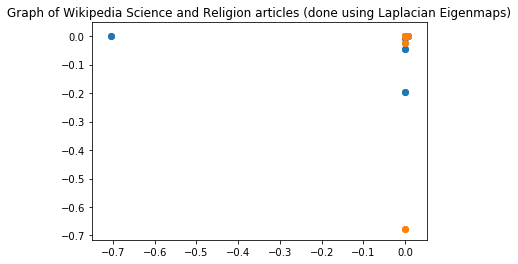

In [64]:
plt.scatter(twoD_embeddings[0:800,0], twoD_embeddings[0:800,1], label=1)
plt.scatter(twoD_embeddings[800:2650,0], twoD_embeddings[800:2650,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

### t-sne

In [65]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
x_embed = tsne.fit_transform(adjacency_matrix)

Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using tSN-E)')

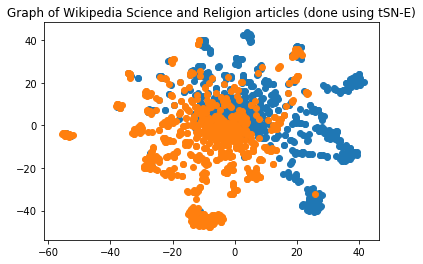

In [66]:
plt.scatter(x_embed[:700,0], x_embed[:700,1], label=1)
plt.scatter(x_embed[700:, 0], x_embed[700:,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using tSN-E)')

# III. Machine Learning

In [142]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl import DGLGraph
import dgl.function as fn

np.random.seed(0)
torch.manual_seed(1)

In [143]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [144]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
       
def test_articles(model, g, features, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask] 
        _, indices = torch.max(logits, dim=1)
        return indices

In [149]:
from sklearn.model_selection import train_test_split
x1, x2, y1, y2, idx1, idx2 = train_test_split(
    adjacency_matrix, words_df_reduced['label'], range(adjacency_matrix.shape[1]), test_size=0.4)
x3, x4, y3, y4, idx3, idx4 = train_test_split(
    x2, y2, idx2, test_size=0.5)

In [150]:
train_df = pd.DataFrame(np.column_stack((idx1, np.ones(len(idx1)).T)), columns = ['idx', 'indices'])
train_ = labels_df.merge(train_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
val_df = pd.DataFrame(np.column_stack((idx3, np.ones(len(idx3)).T)), columns = ['idx', 'indices'])
val_ = labels_df.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
test_df = pd.DataFrame(np.column_stack((idx4, np.ones(len(idx4)).T)), columns = ['idx', 'indices'])
test_ = labels_df.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)

AttributeError: 'Series' object has no attribute 'merge'

In [151]:
features.shape

(1400, 100)

In [152]:
in_feats = features.shape[1] 
n_classes = 2
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 100
p_dropout = 0.8
features_ = torch.FloatTensor(features) 
labels = torch.LongTensor(labels_df['label']) 
train_mask = torch.BoolTensor(train_['indices'])
val_mask = torch.BoolTensor(val_['indices'])
test_mask = torch.BoolTensor(test_['indices'])

ValueError: could not determine the shape of object type 'DataFrame'

In [153]:
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

graph = DGLGraph(graph)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features_, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features_, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features_, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

NameError: name 'features_' is not defined

In [146]:
coeff_gcn =  model.pol_weights.data.numpy()
print(coeff_gcn)

NameError: name 'model' is not defined

In [147]:
model

NameError: name 'model' is not defined

In [ ]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    # Your code here
    V = np.vander(lam, len(coeff), increasing=True)
    return V@coeff

In [ ]:
plt.semilogy(lam, np.abs(polynomial_graph_filter_response(coeff_gcn, lam)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')

In [ ]:
list_articles = ["God", "Network Science", "Jesus", "Quantic physics"]
test_df = take_words(list_articles, is_title = True)

In [ ]:
test = make_features(test_df)
features_final = np.concatenate((features, test))

In [ ]:
distances = np.array([[(np.sum((features_final[i,:]-features_final[j,:])**2)) for i in range(0,features_final.shape[0]) ] for j in range(0,features_final.shape[0])]).reshape(features_final.shape[0],-1)
feat = distances/np.max(distances)
np.fill_diagonal(feat, 0)
graph = nx.from_numpy_array(feat)
graph = DGLGraph(graph)

In [ ]:
features_ = torch.FloatTensor(features_final)

In [ ]:
mask1 = np.zeros((len(features)))
mask2 = np.ones((len(test)))
mask = np.concatenate((mask1,mask2))
mask = torch.BoolTensor(mask)

In [ ]:
test_articles(model, graph, features_, mask)

In [ ]:
model.pol_weights

In [ ]:
model.logr_weights

## Cheeger constant

In [ ]:
matrixu()

## Heuristic Eigengaps

In [ ]:
laplacian = matrixu.compute_laplacian(adjacency_matrix, normalize = False)
eigenvalues, eigenvectors = matrixu.spectral_decomposition(laplacian)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(eigenvalues)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')

In [ ]:
eigenvalues[2000]